In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, precision_recall_curve, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# 导入数据

In [2]:
Cname = [
    'age', 'wc', 'fnlwgt', 'edu', 'edu-num', 'ms', 'occ', 'rs', 'race', 'sex',
    'cap-g', 'cap-l', 'hpw', 'native', 'y'
]
df = pd.read_csv('./adult.data',
                 sep=', ',
                 header=None,
                 names=Cname,
                 engine='python')

# 数据集描述

In [3]:
df.shape

(32561, 15)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age        32561 non-null int64
wc         32561 non-null object
fnlwgt     32561 non-null int64
edu        32561 non-null object
edu-num    32561 non-null int64
ms         32561 non-null object
occ        32561 non-null object
rs         32561 non-null object
race       32561 non-null object
sex        32561 non-null object
cap-g      32561 non-null int64
cap-l      32561 non-null int64
hpw        32561 non-null int64
native     32561 non-null object
y          32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [5]:
df.describe()

,age,fnlwgt,edu-num,cap-g,cap-l,hpw
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [6]:
# 缺失值统计
df.replace('?', np.nan, inplace=True)
df.isnull().sum()[df.isnull().sum()>0]

wc        1836
occ       1843
native     583
dtype: int64

# 探索性数据分析

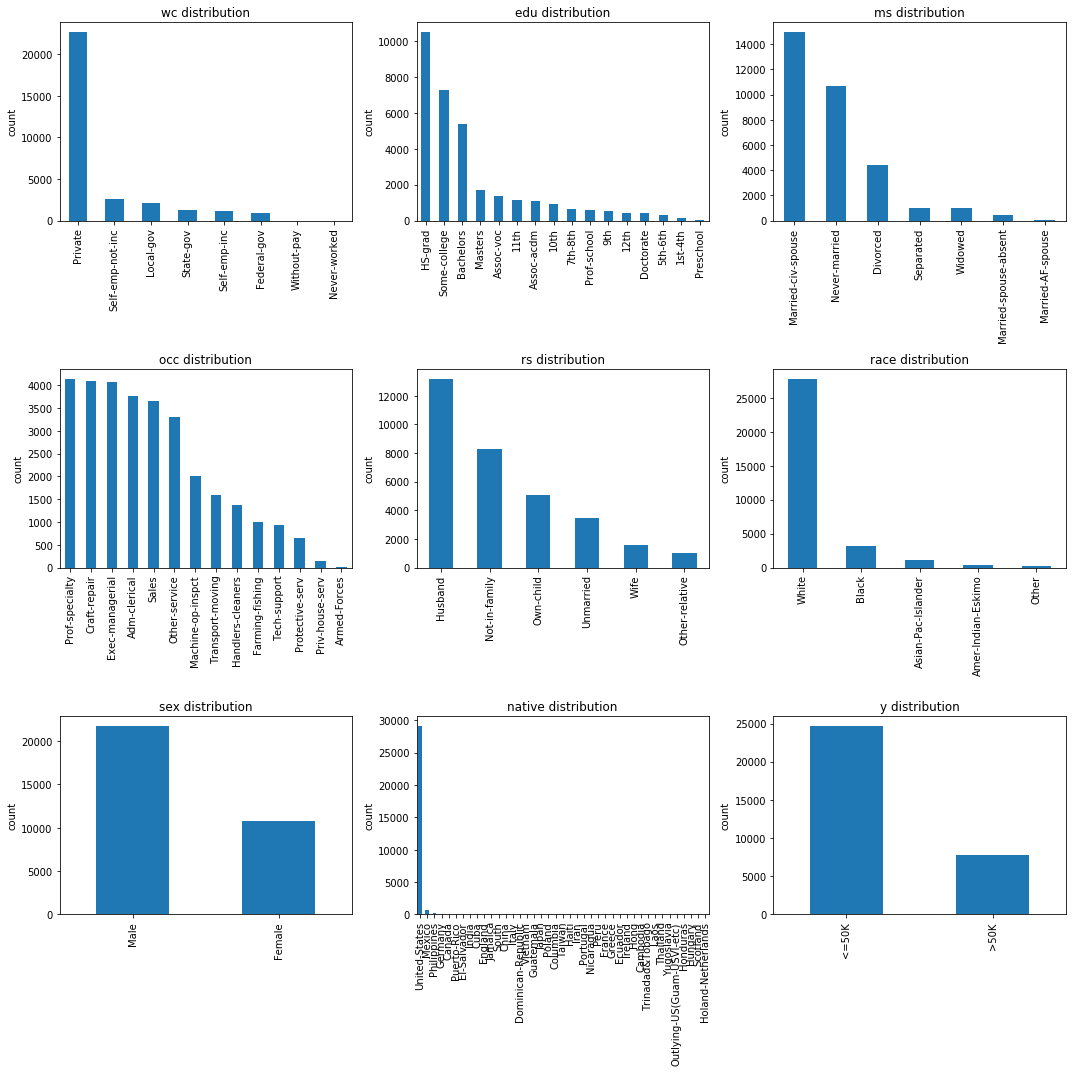

In [7]:
cols = df.select_dtypes(include = [np.object]).columns
plt.figure(figsize=(15,15))
for i in range(len(cols)):
    plt.subplot(3,3,i+1)
    df[cols[i]].value_counts().plot.bar()
    plt.title('%s distribution' % cols[i])
    plt.ylabel('count')
    plt.tight_layout()

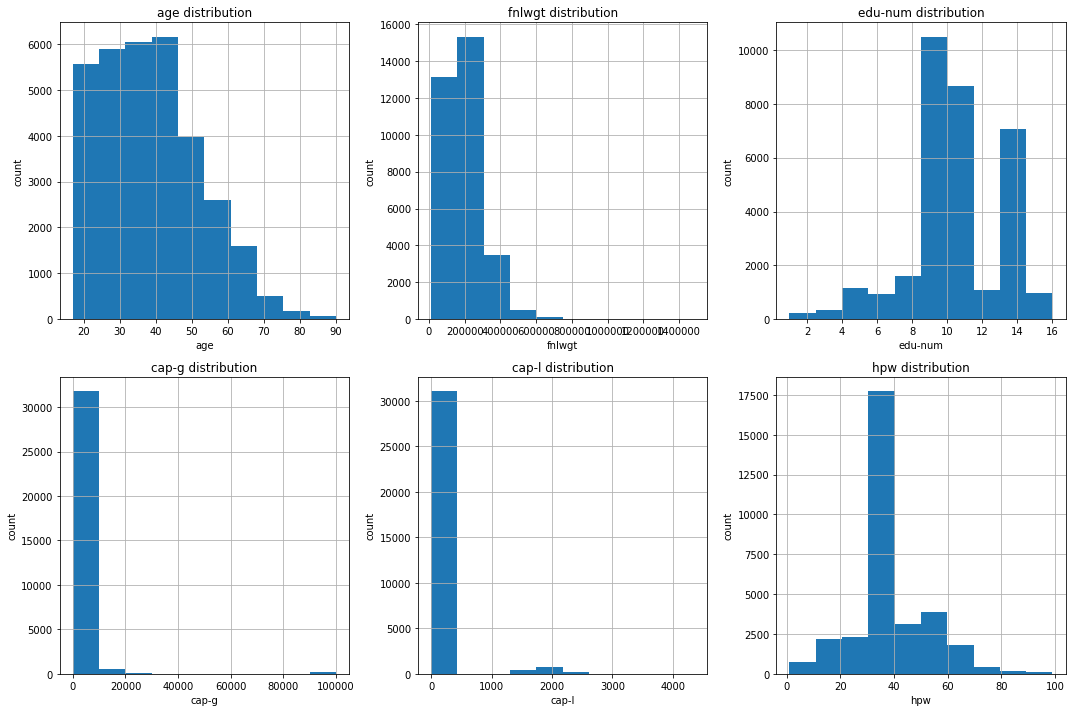

In [8]:
cols = df.select_dtypes(include = [np.number]).columns
plt.figure(figsize=(15,10))
for i in range(len(cols)):
    plt.subplot(2,3,i+1)
    df[cols[i]].hist()
    plt.title('%s distribution' % cols[i])
    plt.xlabel(cols[i])
    plt.ylabel('count')
    plt.tight_layout()

# 方法

In [9]:
# 对y进行二分类，>50K置为1表示高收入，否则置为0表示低收入
df['Income_level'] = df.y.apply(lambda x: 1 if x == '>50K' else 0)
# drop掉y列
df.drop('y', axis=1, inplace=True)

In [10]:
# 删除缺失值
df.dropna(axis=0, inplace=True)
df.shape

(30162, 15)

In [11]:
# 离散特征处理：ont-hot encoding
discrete_cols = df.select_dtypes(include = [np.object]).columns
df_onthot = pd.get_dummies(df[discrete_cols])

In [12]:
# 连续特征处理：归一化
continuous_cols = list(df.select_dtypes(include = [np.number]).columns)
continuous_cols.remove('Income_level')
scaler = MinMaxScaler()
df[continuous_cols] = scaler.fit_transform(df[continuous_cols])

In [13]:
# 切分训练集和测试集
X = pd.concat([df[continuous_cols], df_onthot], sort=False, axis=1) 
y = df['Income_level']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [14]:
# 建立逻辑回归模型
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# 结果和讨论

In [15]:
# TPR, TNR, FPR, FNR
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      6767
           1       0.75      0.60      0.67      2282

    accuracy                           0.85      9049
   macro avg       0.81      0.77      0.78      9049
weighted avg       0.84      0.85      0.84      9049



In [16]:
# accuracy
print('accuracy: %.4f' % accuracy_score(y_test, y_pred))

accuracy: 0.8480


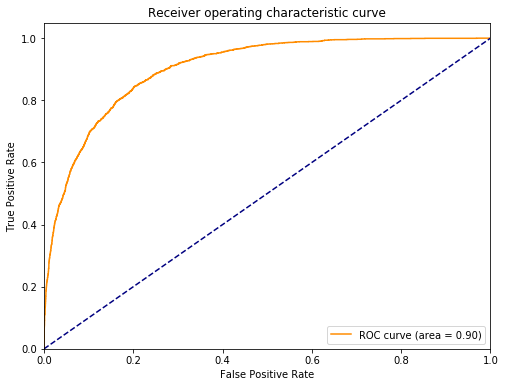

In [17]:
y_score = lr.decision_function(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_score)  ###计算真正率和假正率
roc_auc = roc_auc_score(y_test, y_score)  ###计算auc的值

plt.figure(figsize=(8, 6))
plt.plot(fpr,
         tpr,
         color='darkorange',
         label='ROC curve (area = %.2f)' % roc_auc)  ###假正率为横坐标，真正率为纵坐标做roc曲线
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")

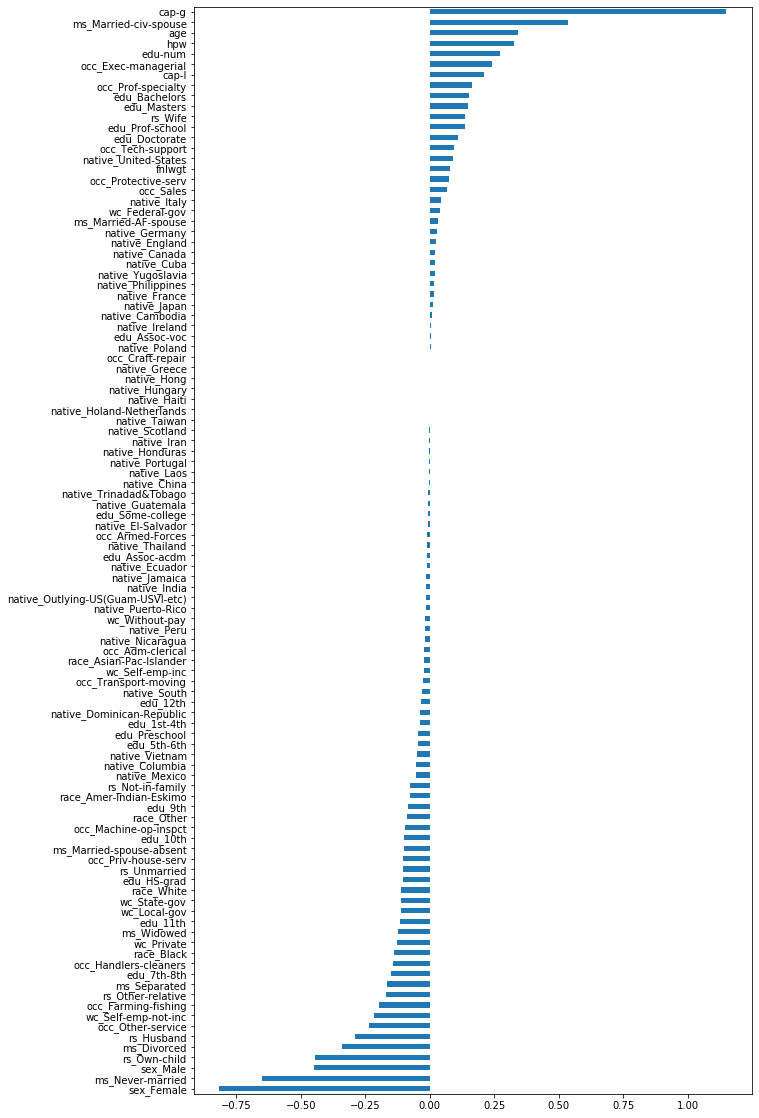

In [18]:
# 结果解释
feature_importance = pd.Series(np.std(X)*lr.coef_[0], index=X.columns)
feature_importance.sort_values(ascending=True, inplace=True)
feature_importance.plot.barh(figsize=(10,20))